### Optimization and Initialization
When increasing the depth of neural networks, there are various challenges we face. Most importantly, we need to have a stable gradient flow through the network, as otherwise, we might encounter vanishing or exploding gradients.

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import numpy as np
import os
import math
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

In [4]:
def set_seed(n):
    torch.manual_seed(n)
    np.random.seed(n)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(n)
        torch.cuda.manual_seed_all(n)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Using device: ", device)

Using device:  cuda:0


In [5]:
DATASET_PATH = "data"
CHECKPOINT_PATH = "saved_models/tutorial3"

In [7]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial4/"
# Files to download
pretrained_files = ["FashionMNIST_SGD.config",    "FashionMNIST_SGD_results.json",    "FashionMNIST_SGD.tar",
                    "FashionMNIST_SGDMom.config", "FashionMNIST_SGDMom_results.json", "FashionMNIST_SGDMom.tar",
                    "FashionMNIST_Adam.config",   "FashionMNIST_Adam_results.json",   "FashionMNIST_Adam.tar"   ]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [8]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# Transformations applied on each image => first make them a tensor, then normalize them with mean 0 and std 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.2861,), (0.3530,))
                               ])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

The normalization values are deduced from the dataset

In [9]:
print("Mean", (train_dataset.data.float() / 255.0).mean().item())
print("Std", (train_dataset.data.float() / 255.0).std().item())

Mean 0.28604060411453247
Std 0.3530242443084717


We can see the statistics of the transormation below. Note that the maximum and minimum are not 1 and -1 anymore, but shifted towards the positive values. This is because FashionMNIST contains a lot of black pixels, similar to MNIST.

In [10]:
imgs, _ = next(iter(train_loader))
print(f"Mean: {imgs.mean().item():5.3f}")
print(f"Standard deviation: {imgs.std().item():5.3f}")
print(f"Maximum: {imgs.max().item():5.3f}")
print(f"Minimum: {imgs.min().item():5.3f}")

Mean: 0.006
Standard deviation: 1.001
Maximum: 2.022
Minimum: -0.810


### Base Network

In [11]:
class BaseNetwork(nn.Module):

    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - Object of the activation function that should be used as non-linearity in the network.
            input_size - Size of the input images in pixels
            num_classes - Number of classes we want to predict
            hidden_sizes - A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.ModuleList(layers) # A module list registers a list of modules as submodules (e.g. for parameters)

        self.config = {"act_fn": act_fn.__class__.__name__, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes}

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            x = l(x)
        return x

In [14]:
class Identity(nn.Module):
    def forward(self, x):
        return x
    
act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "Identity": Identity
}

### Utility Visualization Functions

In [15]:
##############################################################
# plot distribution of weight values
def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index%columns]
        sns.histplot(val_dict[key], ax=key_ax, color=color, bins=50, stat=stat,
                     kde=use_kde and ((val_dict[key].max()-val_dict[key].min())>1e-8)) # Only plot kde if there is variance
        key_ax.set_title(f"{key} " + (r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape)>1 else ""))
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig

##############################################################
# visualize weight matrix post ravel operation and skip bias
def visualize_weight_distribution(model, color="C0"):
    weights = {}
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            continue
        key_name = f"Layer {name.split('.')[1]}"
        weights[key_name] = param.detach().view(-1).cpu().numpy()

    ## Plotting
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

##############################################################

def visualize_gradients(model, color="C0", print_variance=False):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    model.zero_grad()
    preds = model(imgs)
    loss = F.cross_entropy(preds, labels) # Same as nn.CrossEntropyLoss, but as a function instead of module
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {name: params.grad.view(-1).cpu().clone().numpy() for name, params in model.named_parameters() if "weight" in name}
    model.zero_grad()

    ## Plotting
    fig = plot_dists(grads, color=color, xlabel="Grad magnitude")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")

##############################################################

def visualize_activations(model, color="C0", print_variance=False):
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    feats = imgs.view(imgs.shape[0], -1)
    activations = {}
    with torch.no_grad():
        for layer_index, layer in enumerate(model.layers):
            feats = layer(feats)
            if isinstance(layer, nn.Linear):
                activations[f"Layer {layer_index}"] = feats.view(-1).detach().cpu().numpy()

    ## Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key} - Variance: {np.var(activations[key])}")


##############################################################

As a starting point for finding a good initialization method, we will analyze different initialization based on our linear neural network with no activation function (i.e. an identity). We do this because initializations depend on the specific activation function used in the network, and we can adjust the initialization schemes later on for our specific choice.

In [16]:
model = BaseNetwork(act_fn=Identity()).to(device)

### Constant initialization
The first initialization we can consider is to initialize all weights with the same constant value. Intuitively, setting all weights to zero is not a good idea as the propagated gradient will be zero. However, what happens if we set all weights to a value slightly larger or smaller than 0? To find out, we can implement a function for setting all parameters below and visualize the gradients.

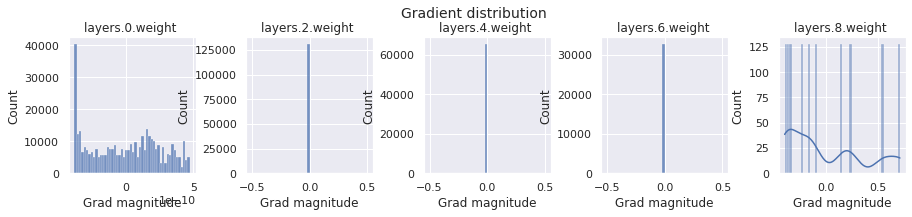

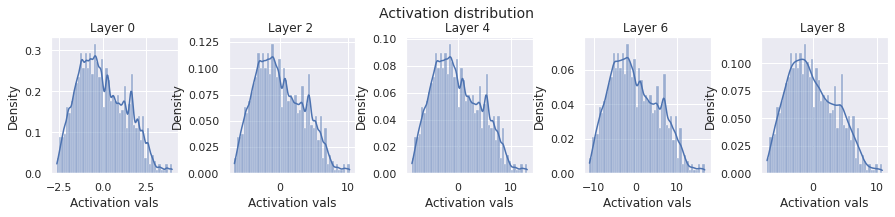

Layer 0 - Variance: 1.9160279035568237
Layer 2 - Variance: 12.556879997253418
Layer 4 - Variance: 20.573190689086914
Layer 6 - Variance: 33.70710754394531
Layer 8 - Variance: 13.806429862976074


In [17]:
def const_init(model, c=0.0):
    for name, param in model.named_parameters():
        param.data.fill_(c)

const_init(model, c=0.005)
visualize_gradients(model)
visualize_activations(model, print_variance=True)

As we can see, only the first and the last layer have diverse gradient distributions while the other three layers have the same gradient for all weights (note that this value is unequal 0, but often very close to it). Having the same gradient for parameters that have been initialized with the same values means that we will always have the same value for those parameters. This would make our layer useless and reduce our effective number of parameters to 1. Thus, we cannot use a constant initialization to train our networks

### Constant variance
From the experiment above, we have seen that a constant value is not working. So instead, how about we initialize the parameters by randomly sampling from a distribution like a Gaussian? The most intuitive way would be to choose one variance that is used for all layers in the network. Let’s implement it below, and visualize the activation distribution across layers.

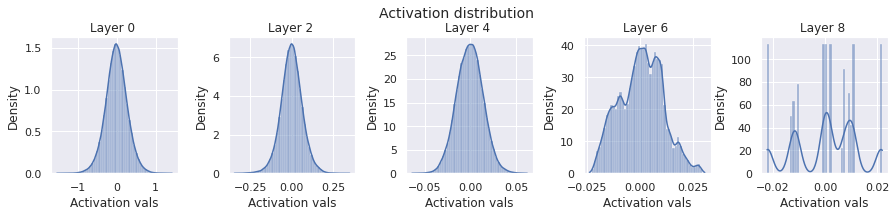

Layer 0 - Variance: 0.07761622965335846
Layer 2 - Variance: 0.004182386212050915
Layer 4 - Variance: 0.00020374970335979015
Layer 6 - Variance: 0.00010472517169546336
Layer 8 - Variance: 0.00014702558110002428


In [18]:
def var_init(model, std=0.01):
    for name, param in model.named_parameters():
        param.data.normal_(std=std)

var_init(model, std=0.01)
visualize_activations(model, print_variance=True)

The variance of the activation becomes smaller and smaller across layers, and almost vanishes in the last layer. Alternatively, we could use a higher standard deviation:

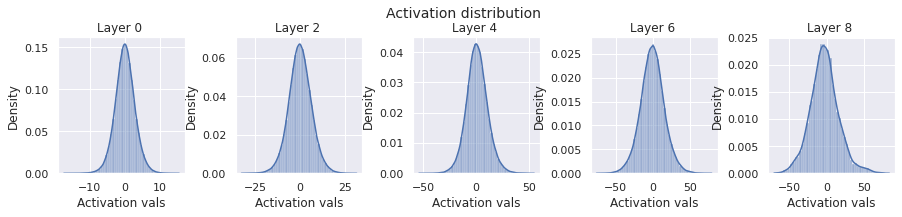

Layer 0 - Variance: 7.881960391998291
Layer 2 - Variance: 39.89569854736328
Layer 4 - Variance: 100.34742736816406
Layer 6 - Variance: 255.28759765625
Layer 8 - Variance: 363.6065368652344


In [19]:
var_init(model, std=0.1)
visualize_activations(model, print_variance=True)

With a higher standard deviation, the activations are likely to explode. You can play around with the specific standard deviation values, but it will be hard to find one that gives us a good activation distribution across layers and is very specific to our model. If we would change the hidden sizes or number of layers, you would have to search all over again, which is neither efficient nor recommended.

### How to find appropriate initialization values
From our experiments above, we have seen that we need to sample the weights from a distribution, but are not sure which one exactly. As a next step, we will try to find the optimal initialization from the perspective of the activation distribution. For this, we state two requirements:

1.The mean of the activations should be zero  
2.The variance of the activations should stay the same across every layer

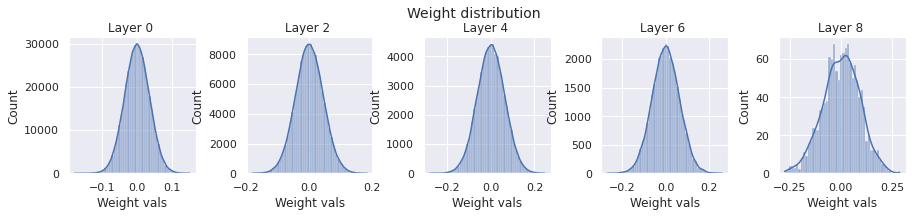

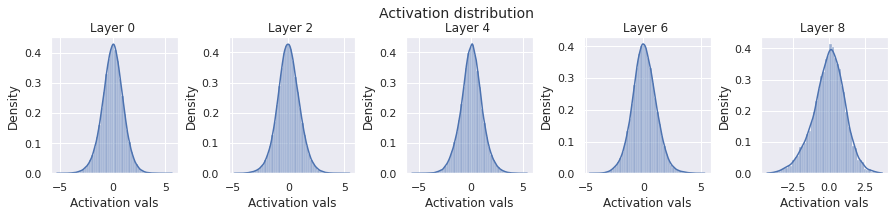

Layer 0 - Variance: 1.010151982307434
Layer 2 - Variance: 0.9943763017654419
Layer 4 - Variance: 1.073542833328247
Layer 6 - Variance: 1.0848195552825928
Layer 8 - Variance: 1.2010905742645264


In [21]:
def equal_var_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            param.data.normal_(std=1.0/math.sqrt(param.shape[1]))

equal_var_init(model)
visualize_weight_distribution(model)
visualize_activations(model, print_variance=True)

As we expected, the variance stays indeed constant across layers. Note that our initialization does not restrict us to a normal distribution, but allows any other distribution with a mean of 0 and variance of 
$1/d_x$. You often see that a uniform distribution is used for initialization. A small benefit of using a uniform instead of a normal distribution is that we can exclude the chance of initializing very large or small weights.

If we use a uniform distribution, we would initialize the weights with xavier initialization.

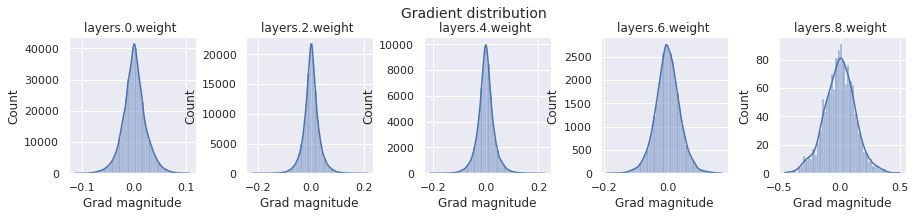

layers.0.weight - Variance: 0.00048473686911165714
layers.2.weight - Variance: 0.0008868800941854715
layers.4.weight - Variance: 0.0009999400936067104
layers.6.weight - Variance: 0.001518618082627654
layers.8.weight - Variance: 0.016462456434965134


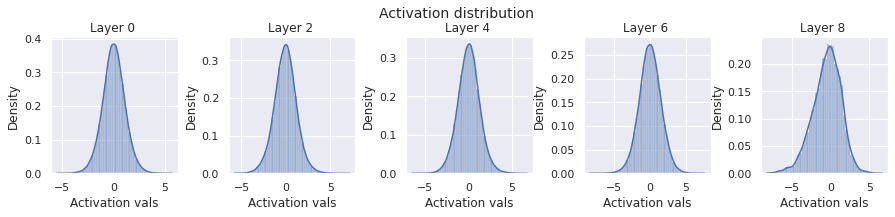

Layer 0 - Variance: 1.1923800706863403
Layer 2 - Variance: 1.5528712272644043
Layer 4 - Variance: 1.5633810758590698
Layer 6 - Variance: 2.283720016479492
Layer 8 - Variance: 3.322671413421631


In [22]:
def xavier_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            bound = math.sqrt(6)/math.sqrt(param.shape[0]+param.shape[1])
            param.data.uniform_(-bound, bound)

xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

Now, we will introduce **TanH** activation

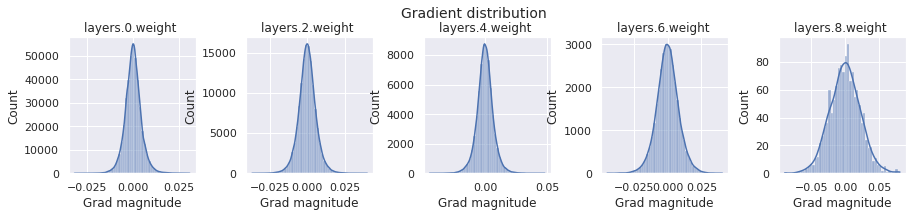

layers.0.weight - Variance: 1.9916511519113556e-05
layers.2.weight - Variance: 3.3900869311764836e-05
layers.4.weight - Variance: 4.261366484570317e-05
layers.6.weight - Variance: 6.648368434980512e-05
layers.8.weight - Variance: 0.0005056529771536589


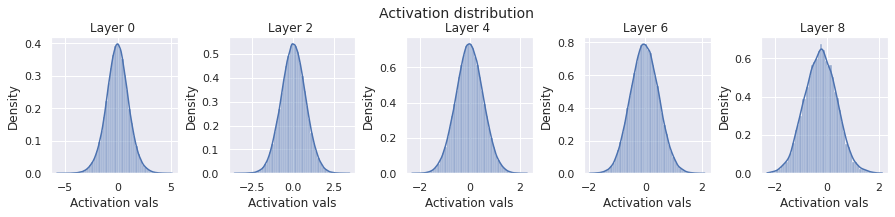

Layer 0 - Variance: 1.143493413925171
Layer 2 - Variance: 0.5546581745147705
Layer 4 - Variance: 0.2960897982120514
Layer 6 - Variance: 0.24759221076965332
Layer 8 - Variance: 0.37805113196372986


In [23]:
model = BaseNetwork(act_fn=nn.Tanh()).to(device)
xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

Although the variance decreases over depth, it is apparent that the activation distribution becomes more focused on the low values. Therefore, our variance will stabilize around 0.25 if we would go even deeper. Hence, we can conclude that the Xavier initialization works well for Tanh networks. 

### Kaiming Initialization

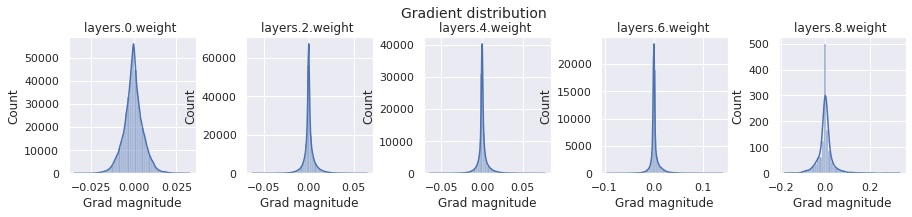

layers.0.weight - Variance: 3.193361044395715e-05
layers.2.weight - Variance: 4.146956780459732e-05
layers.4.weight - Variance: 4.420596087584272e-05
layers.6.weight - Variance: 0.0001023033692035824
layers.8.weight - Variance: 0.001529468921944499


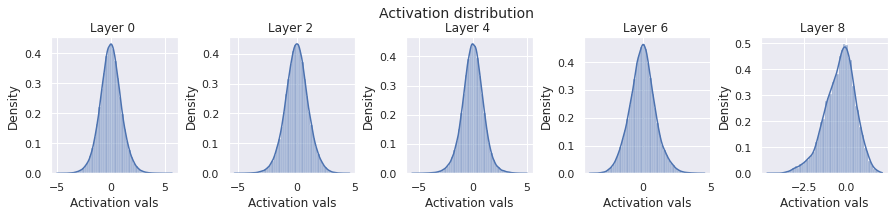

Layer 0 - Variance: 0.9844920039176941
Layer 2 - Variance: 0.9670171141624451
Layer 4 - Variance: 0.9562897682189941
Layer 6 - Variance: 0.8919439911842346
Layer 8 - Variance: 0.8051945567131042


In [24]:
def kaiming_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        elif name.startswith("layers.0"): # The first layer does not have ReLU applied on its input
            param.data.normal_(0, 1/math.sqrt(param.shape[1]))
        else:
            param.data.normal_(0, math.sqrt(2)/math.sqrt(param.shape[1]))

model = BaseNetwork(act_fn=nn.ReLU()).to(device)
kaiming_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

The variance stays stable across layers. We can conclude that the Kaiming initialization indeed works well for ReLU-based networks. Note that for Leaky-ReLU etc., we have to slightly adjust the factor of 
 in the variance as half of the values are not set to zero anymore.